In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
import os
homedir = os.path.expanduser('~')
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
import emcee
import scipy.stats as st
import arviz as az
import corner

In [2]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCK*_1f.spec.fits'))
fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [3]:
obs=22
order=4
target="W1049B"
band="K"

resultdir = f"run_IGRINS_{target}_{band}_order{order}"
if not os.path.exists(resultdir):
    os.mkdir(resultdir)

wl_order = wls[obs, order, :] *10000
flux_order = fobs0[order]
data = Spectrum(wl_order, flux_order, sigmas=None, masks=None, name="Spectrum")

### Setting up the model
Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

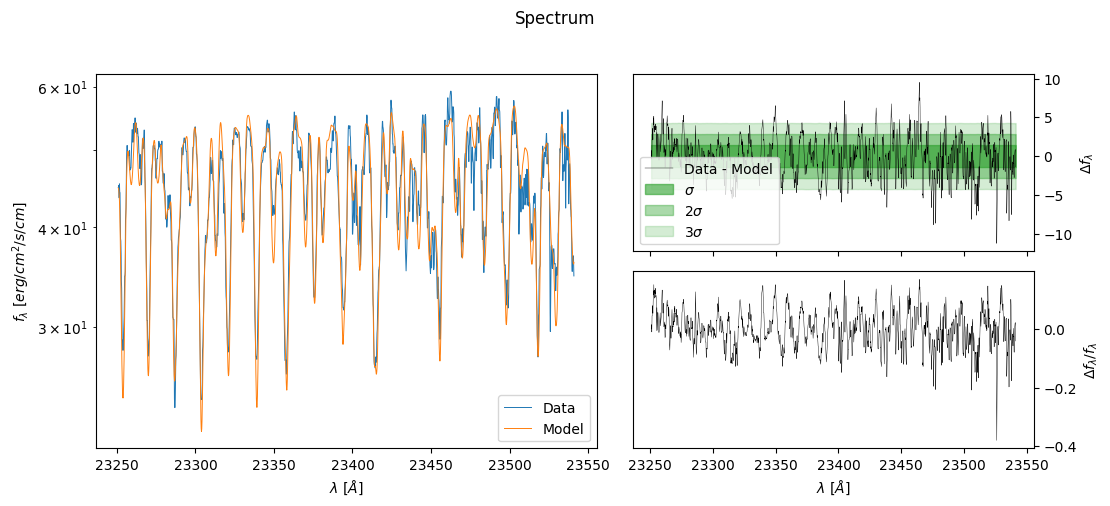

In [4]:
model = SpectrumModel(
    emulator="BTSettl_K_emu.hdf5",
    data=data,
    grid_params=[1500, 5.0],
    vsini=25,
    vz=105,
    cheb=[0, 0],
    global_cov=dict(log_amp=0, log_ls=1),
)
model.plot()
model
model.save(f"{resultdir}/model_created.toml")

#### MCMC Sampling

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [5]:
string = """priors = {
    "T": st.uniform(1200,1950),
    "logg": st.uniform(3.0,5.0),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6),
    "cheb:2": st.uniform(-3, 6),
    "global_cov:log_amp": st.norm(0, 5),
    "global_cov:log_ls": st.uniform(0, 10),
}"""
exec(string)
with open(f"{resultdir}/priors.txt", "w") as f:
    f.write(string)
print(model.log_likelihood(priors))
print(string)

-2014.0040067983512
priors = {
    "T": st.uniform(1200,1950),
    "logg": st.uniform(3.0,5.0),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6),
    "cheb:2": st.uniform(-3, 6),
    "global_cov:log_amp": st.norm(0, 5),
    "global_cov:log_ls": st.uniform(0, 10),
}


In [6]:
#model.load("example_MAP_1.toml")
model.freeze("logg")
model.labels  # These are the fittable parameters

('vsini',
 'vz',
 'global_cov:log_amp',
 'global_cov:log_ls',
 'cheb:1',
 'cheb:2',
 'T')

Numerical Optimization

In [7]:
%time model.train(priors, options={"maxiter": 100})

KeyboardInterrupt: 

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1816.0220460436108

Parameters
  vsini: 27.691100030090624
  vz: 104.12346785619917
  global_cov:
    log_amp: 0.0005120778213497433
    log_ls: 0.45343815439453294
  cheb: [0.000610315384558678, 0.00029996914676966063]
  T: 1508.430757229923
  log_scale: 3.953662344754251 (fit)

Frozen Parameters
  logg: 5.0

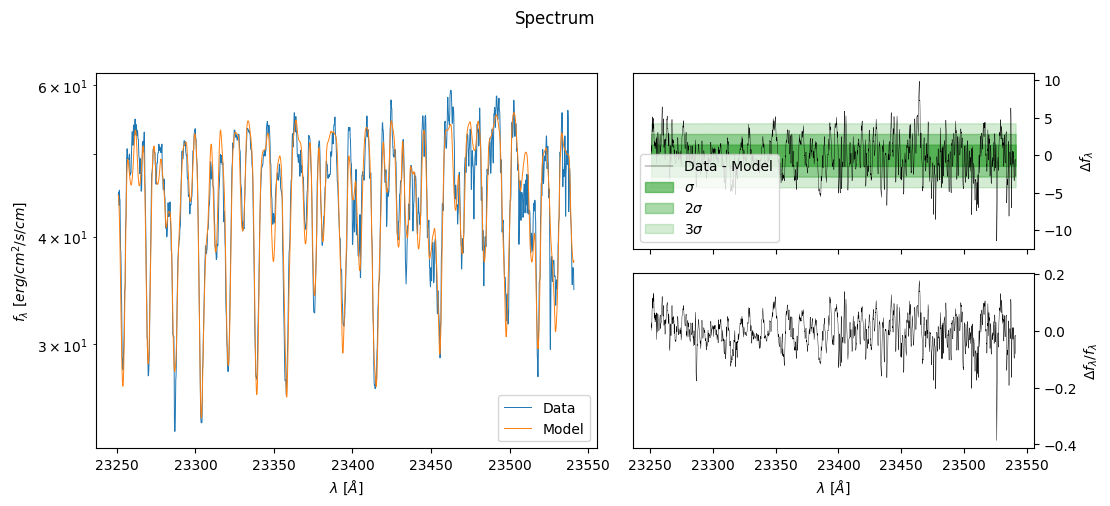

In [8]:
model.plot()
#model.freeze("global_cov")
model

In [13]:
# Set our walkers and dimensionality
nwalkers = 14
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "logg":3, "vsini": 1, "vz": 1, "cheb:1": 1, "cheb:2":1, 'global_cov:log_amp':1, 'global_cov:log_ls':1}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [14]:
max_n = 50

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.02)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

  0%|          | 0/50 [00:00<?, ?it/s]/Users/spacegrey/workspace/dopplerimg/venv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 20%|██        | 10/50 [00:29<02:11,  3.28s/it]/Users/spacegrey/workspace/dopplerimg/venv/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
100%|██████████| 50/50 [03:08<00:00,  3.76s/it]


Parallelized version

In [86]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

nwalkers = 10
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1}
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(priors,), backend=backend
    )

    max_n = 500

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
        # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
        # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau

  0%|          | 1/500 [00:33<4:37:54, 33.42s/it]Traceback (most recent call last):
  File "/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3116325/373837380.py", line 17, in log_prob
    return model.log_likelihood(priors)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 296, in __call__
    fluxes = resample(wave, fluxes, self.data.wave)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in resample
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) for fl in flux]
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in <listcomp>
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) fo

emcee: Exception while calling your likelihood function:
  params: [  23.88068875  107.39306848 1490.99562051]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18b0d0>, 'vsini': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055d8638e0>, 'vz': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18bfa0>},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [15]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True, store=True);

100%|██████████| 100/100 [05:32<00:00,  3.32s/it]


#### MCMC Chain Analysis

In [8]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

AttributeError: You must run the sampler with 'store == True' before accessing the results

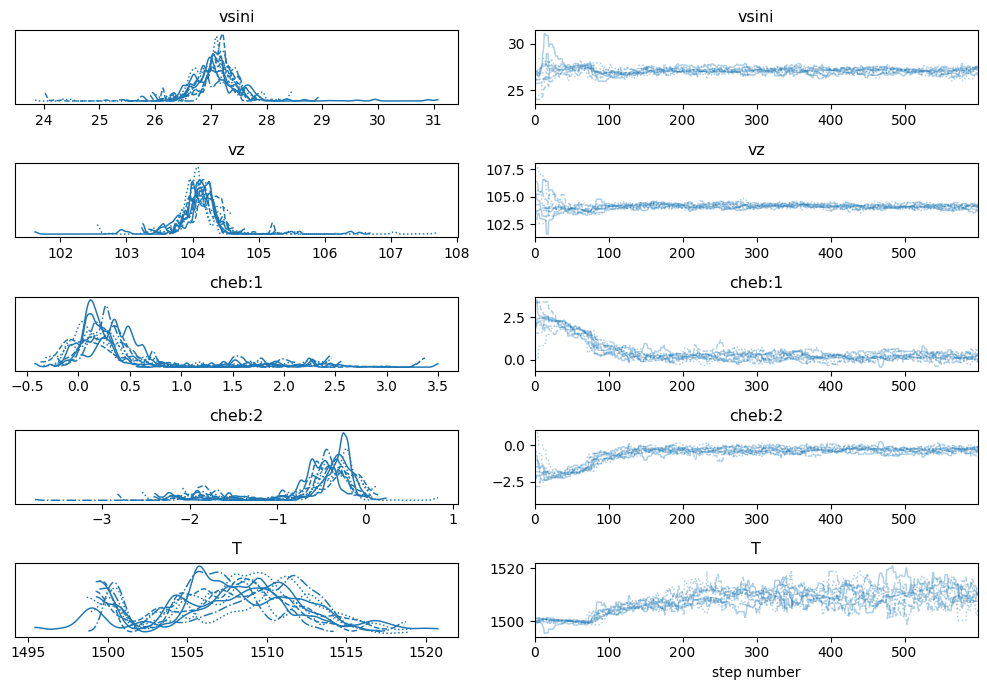

In [29]:
az.plot_trace(full_data, figsize=(10,7));
plt.xlabel("step number")
plt.tight_layout()

After seeing our full traces, let's discard and thin some of the burn-in

In [30]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

In [19]:
tau

array([28.78127507, 31.19397061, 64.99251379, 64.46753604, 67.72666283])

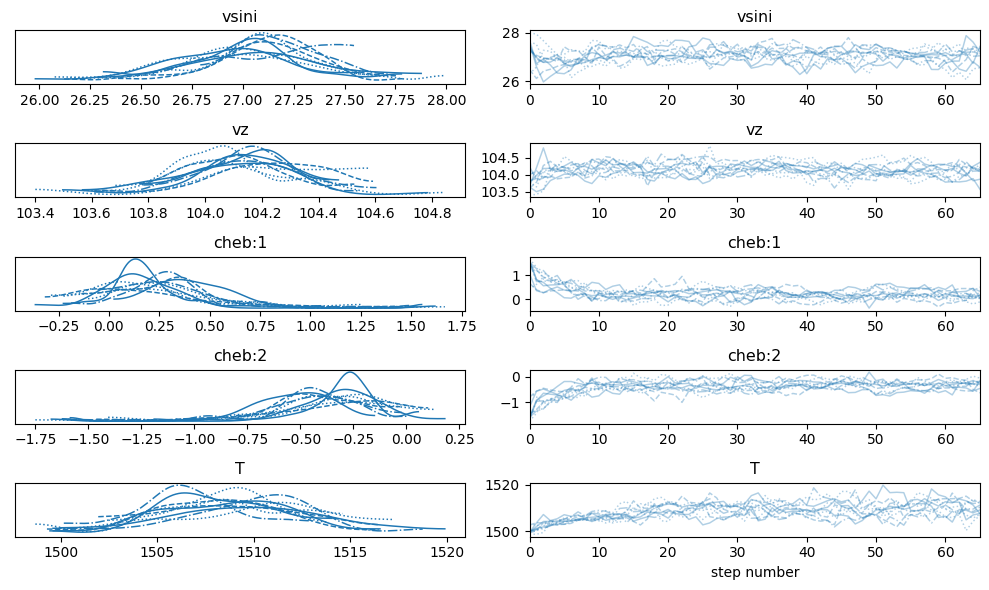

In [31]:
az.plot_trace(burn_data, figsize=(10,6));
plt.xlabel("step number")
plt.tight_layout()

In [32]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vsini,27.066,0.304,26.484,27.638,0.027,0.019,123.0,277.0,1.07
vz,104.133,0.199,103.807,104.536,0.023,0.016,72.0,139.0,1.11
cheb:1,0.256,0.281,-0.232,0.743,0.039,0.028,45.0,146.0,1.16
cheb:2,-0.397,0.266,-0.819,0.078,0.036,0.025,48.0,155.0,1.15
T,1508.581,3.610,1502.259,1515.425,0.524,0.373,48.0,100.0,1.15


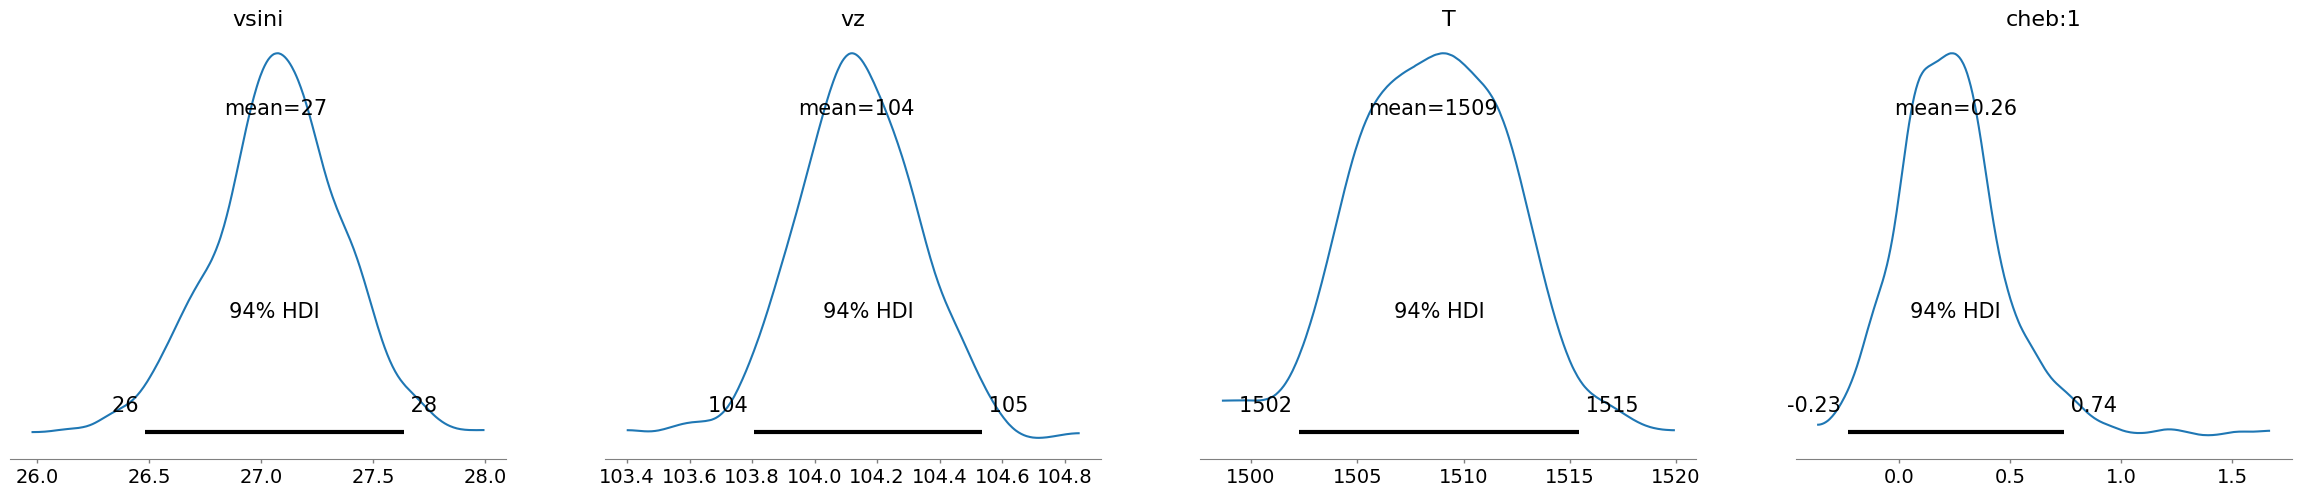

In [33]:
az.plot_posterior(burn_data, ["vsini", "vz", "T", "cheb:1"]);

In [39]:
burn_samples.reshape((-1, 4))

array([[ 2.73672866e+01,  1.03633578e+02,  1.05050112e+00,
        -1.19112539e+00],
       [ 1.49997650e+03,  2.63065011e+01,  1.03793509e+02,
         4.01066963e-01],
       [-6.23069890e-01,  1.50343222e+03,  2.64843677e+01,
         1.03997454e+02],
       ...,
       [-1.89355742e-01,  1.51132937e+03,  2.74360210e+01,
         1.03566526e+02],
       [ 1.72421266e-01, -3.07324803e-01,  1.50754606e+03,
         2.70306766e+01],
       [ 1.04288269e+02,  4.54090649e-02, -1.94292476e-01,
         1.50679087e+03]])

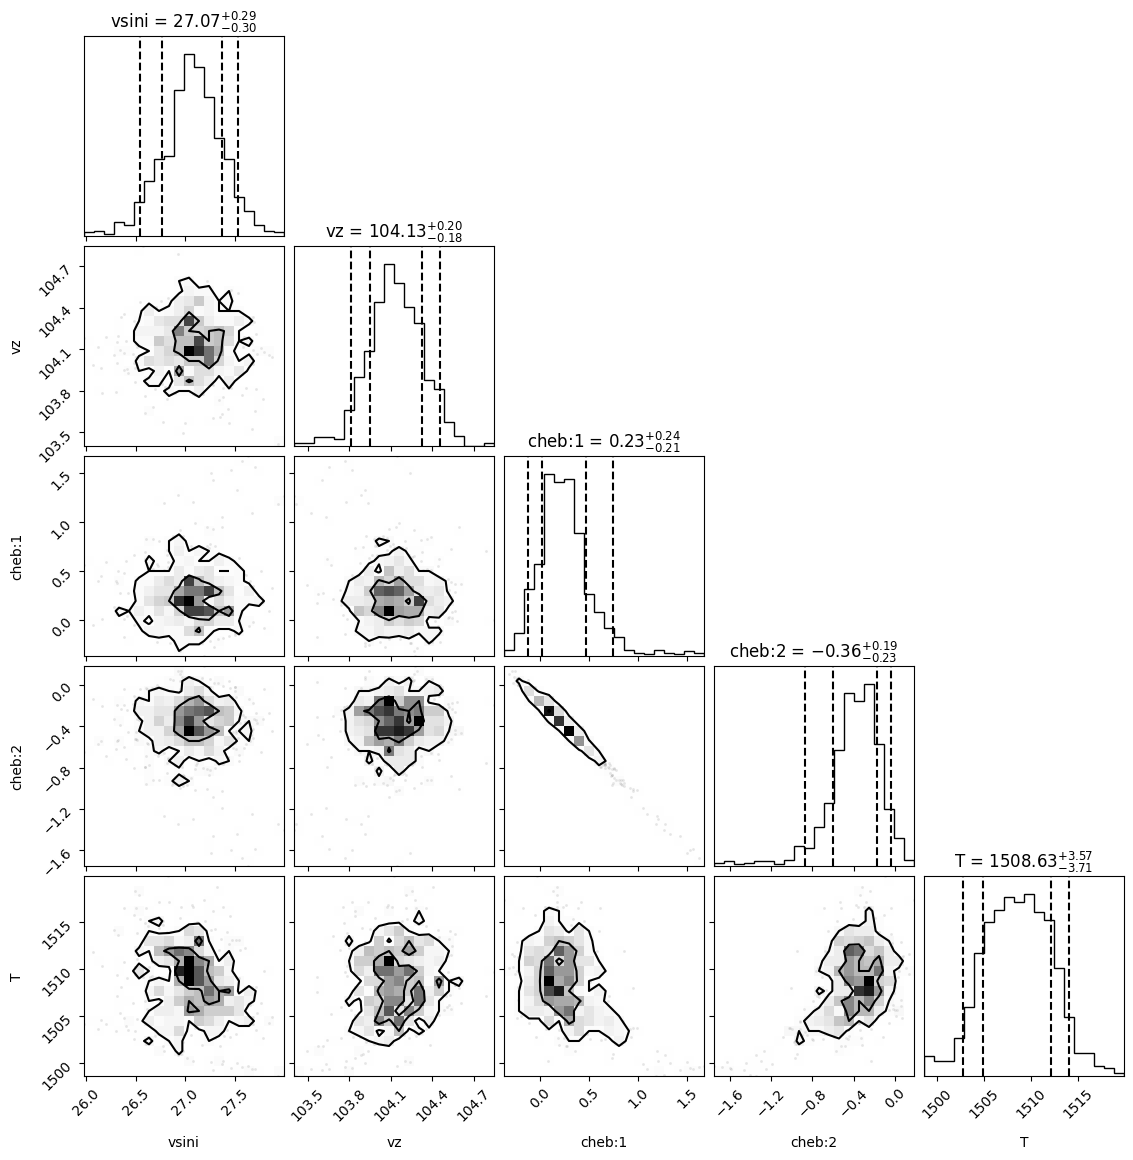

In [41]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
#all_samples = reader.get_chain()
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 5)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True
);

After looking at our posteriors, let's look at our fit

In [35]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1901.433949161679

Parameters
  vsini: 27.066
  vz: 104.133
  cheb: [0.256, -0.397]
  T: 1508.581
  log_scale: 4.091856596194488 (fit)

Frozen Parameters
  logg: 5.0
  global_cov:log_amp: 0
  global_cov:log_ls: 1

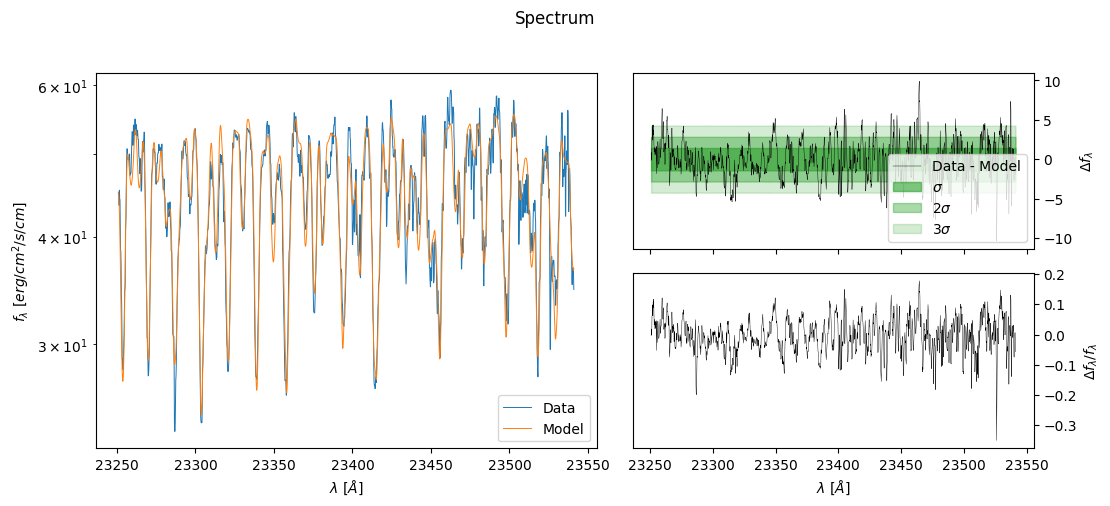

In [36]:
model.plot();

and finally, we can save our best fit.

In [50]:
model.save("example_sampled_1.toml")

Now, on to the next star!